In [1]:


import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
)

# Clasificator Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# =======================
# Parametri generali
# =======================
DATASET_PATH = "Data/genres_original"  # Ajustează calea la structura ta
SAMPLE_RATE = 22050
SNIPPET_DURATIONS = [3]  # fragmente de 1s și 3s
OVERLAP_RATIO = 0.5  # 25% suprapunere
NUM_MFCC = 13  # nr. coeficienți MFCC
N_FFT = 2048
HOP_LENGTH = 512

# Dimensiunea fixă pe axa timp la care vom redimensiona
TARGET_TIME_FRAMES = 130

def pad_or_truncate(feature, target_len):
    if feature.shape[1] < target_len:
        pad_width = target_len - feature.shape[1]
        feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
    else:
        feature = feature[:, :target_len]
    return feature


def extract_features(
        y,
        sr,
        num_mfcc=NUM_MFCC,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        target_len=TARGET_TIME_FRAMES
):

    # MFCC
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=num_mfcc,
        n_fft=n_fft, hop_length=hop_length
    )
    mfcc = pad_or_truncate(mfcc, target_len)

    # Chroma Frequencies
    chroma = librosa.feature.chroma_stft(
        y=y, sr=sr,
        n_fft=n_fft, hop_length=hop_length
    )
    chroma = pad_or_truncate(chroma, target_len)

    # Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(
        y=y, sr=sr,
        n_fft=n_fft, hop_length=hop_length
    )
    spec_contrast = pad_or_truncate(spec_contrast, target_len)

    # (Opțional) Mel-Spectrogram
    # mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    # mel_spec_db = pad_or_truncate(mel_spec_db, target_len)

    # Ex: MFCC(13,130), Chroma(12,130), Spectral Contrast(7,130) => (32, 130)
    combined_features = np.concatenate((mfcc, chroma, spec_contrast), axis=0)
    return combined_features


def preprocess_data(
        dataset_path=DATASET_PATH,
        snippet_durations=SNIPPET_DURATIONS,
        overlap_ratio=OVERLAP_RATIO
):

    data = []
    labels = []
    genre_count = 0

    for dirpath, _, filenames in os.walk(dataset_path):
        if dirpath == dataset_path:
            continue  # sărim peste rădăcină

        genre = os.path.basename(dirpath)
        genre_count += 1
        print(f"{genre_count}) Procesăm genul: {genre}")

        for file in filenames:
            if file.lower().endswith(".wav"):
                file_path = os.path.join(dirpath, file)
                try:
                    # Încărcăm fișierul audio
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # Segmentare pentru fiecare durată (1s, 3s)
                    for duration in snippet_durations:
                        snippet_length = int(duration * sr)
                        step_size = int(snippet_length * (1 - overlap_ratio)) or snippet_length

                        for start in range(0, len(signal) - snippet_length + 1, step_size):
                            snippet = signal[start:start + snippet_length]
                            feats = extract_features(snippet, sr)
                            data.append(feats)
                            labels.append(genre)

                except Exception as e:
                    print(f"Eroare la fișierul {file_path}: {e}")

    return np.array(data), np.array(labels)



print("Pornim procesarea dataset-ului...")
X, y = preprocess_data(DATASET_PATH)
print(f"Forma lui X: {X.shape}")  # (num_segmente, 32, 130)
print(f"Număr total etichete: {len(y)}")

num_segments, num_feat, num_t_frames = X.shape

# Standardizare
X_2d = X.reshape(num_segments, -1)  # (samples, 32*130)
scaler = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)
X = X_2d_scaled.reshape(num_segments, num_feat, num_t_frames)  # (samples, 32, 130)

# Encodare etichete
encoder = LabelEncoder()
y_numeric = encoder.fit_transform(y)  # numeric 0..N-1
y_categorical = to_categorical(y_numeric)  # one-hot


X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_numeric = np.argmax(y_train, axis=1)
y_test_numeric = np.argmax(y_test, axis=1)

accuracies = {}

Pornim procesarea dataset-ului...
1) Procesăm genul: pop
2) Procesăm genul: metal
3) Procesăm genul: disco
4) Procesăm genul: blues
5) Procesăm genul: reggae
6) Procesăm genul: classical
7) Procesăm genul: rock
8) Procesăm genul: hiphop
9) Procesăm genul: country
10) Procesăm genul: jazz


/var/folders/jm/sspkp1jd65l54k1fw6h0hq5w0000gn/T/ipykernel_22363/1094081514.py:106: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/Users/mihaiosan/PycharmProjects/ProiectIA/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Eroare la fișierul Data/genres_original/jazz/jazz.00054.wav: 
Forma lui X: (18972, 32, 130)
Număr total etichete: 18972
X_train: (13280, 32, 130), y_train: (13280, 10)
X_test:  (5692, 32, 130), y_test:  (5692, 10)


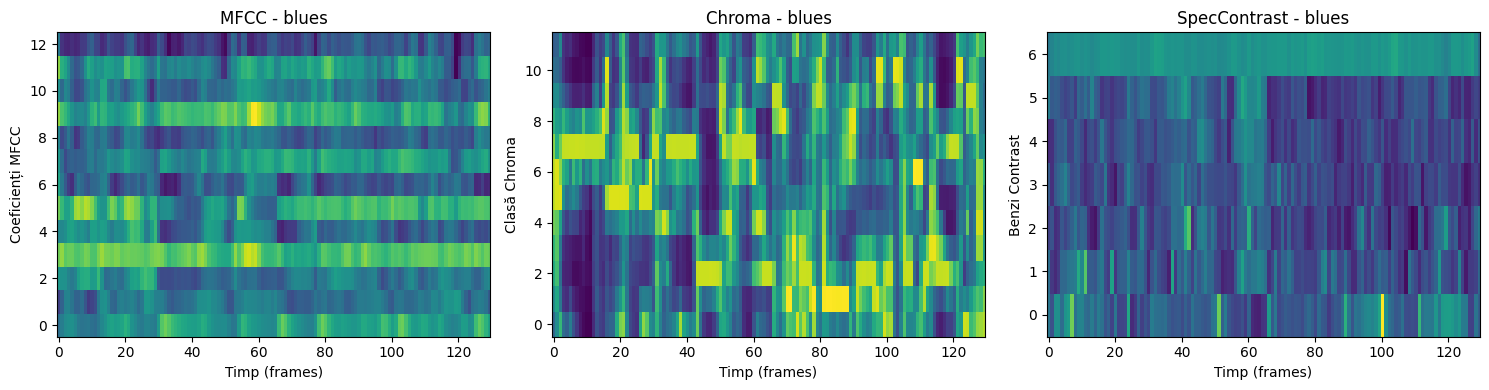

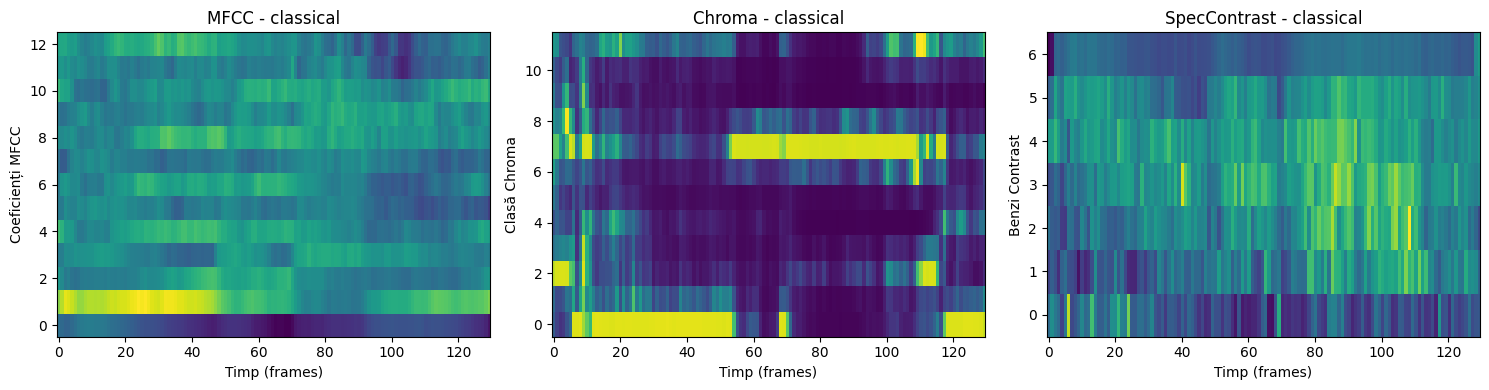

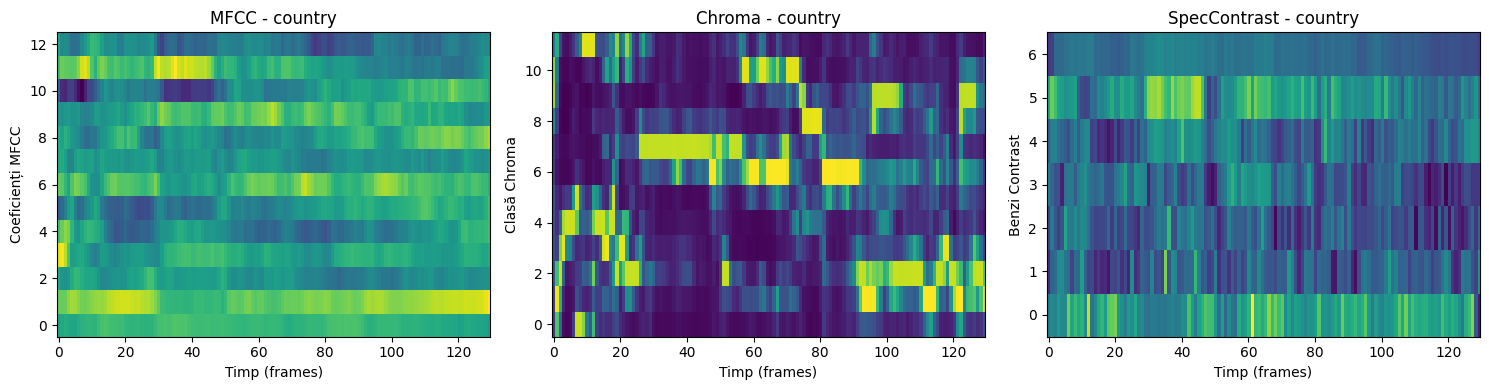

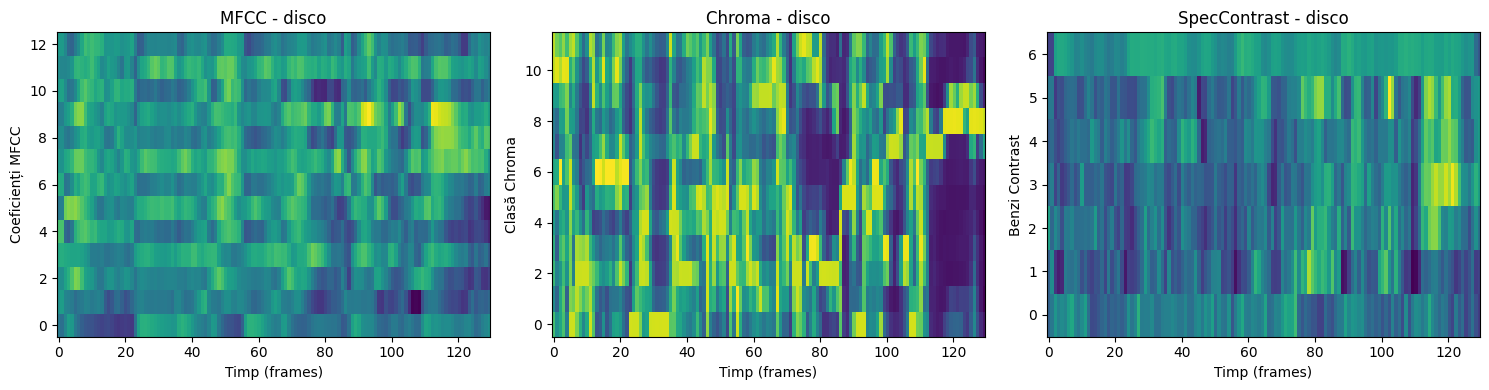

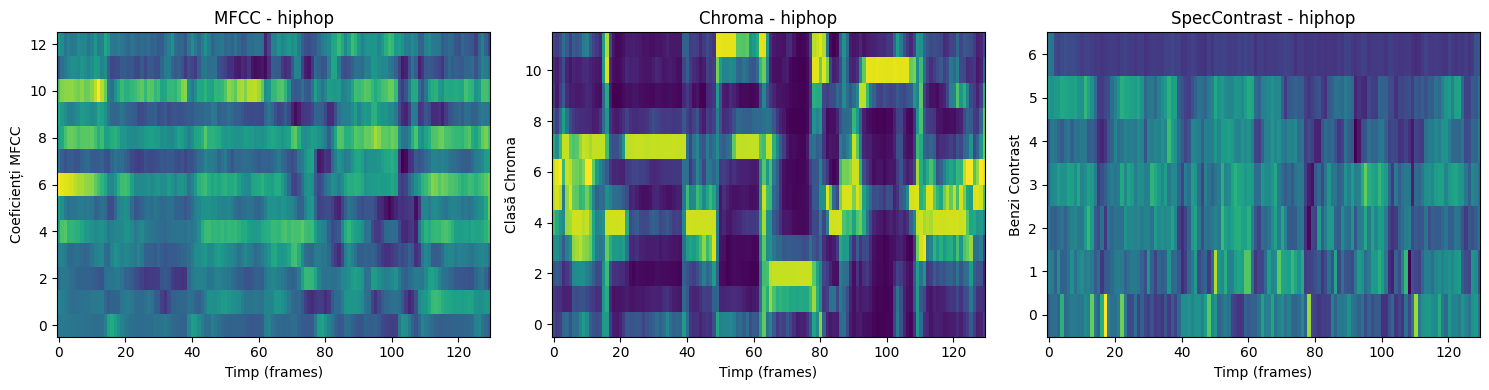

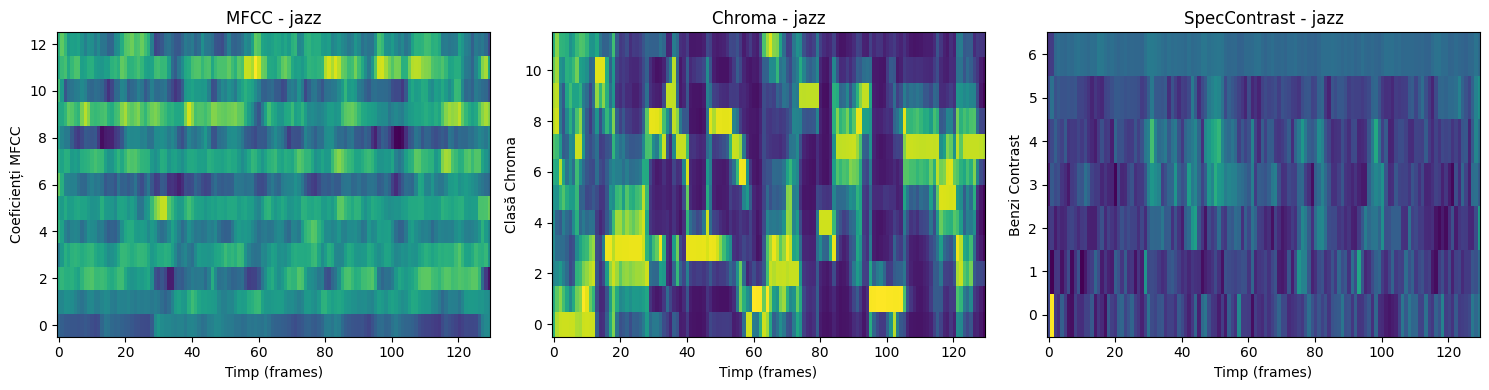

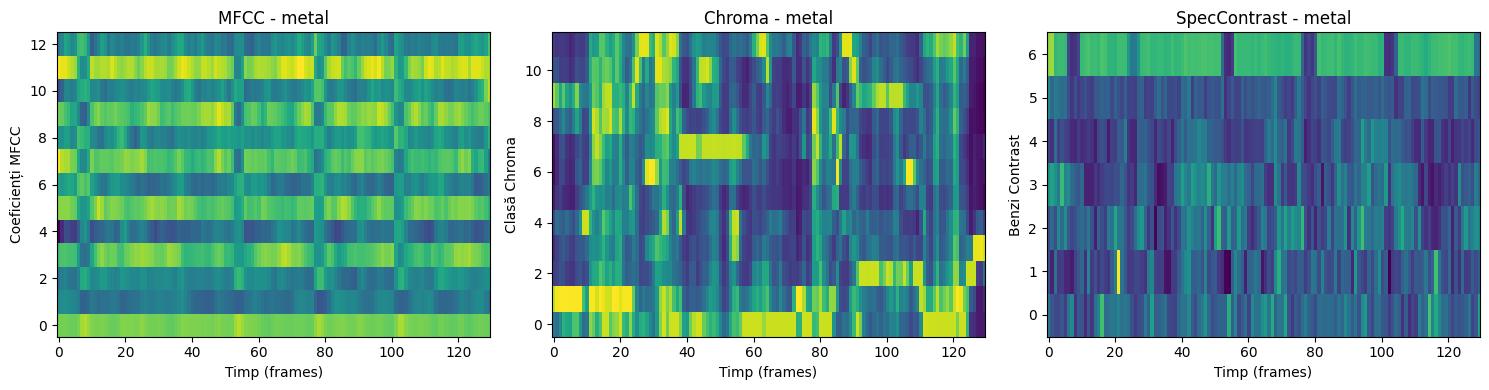

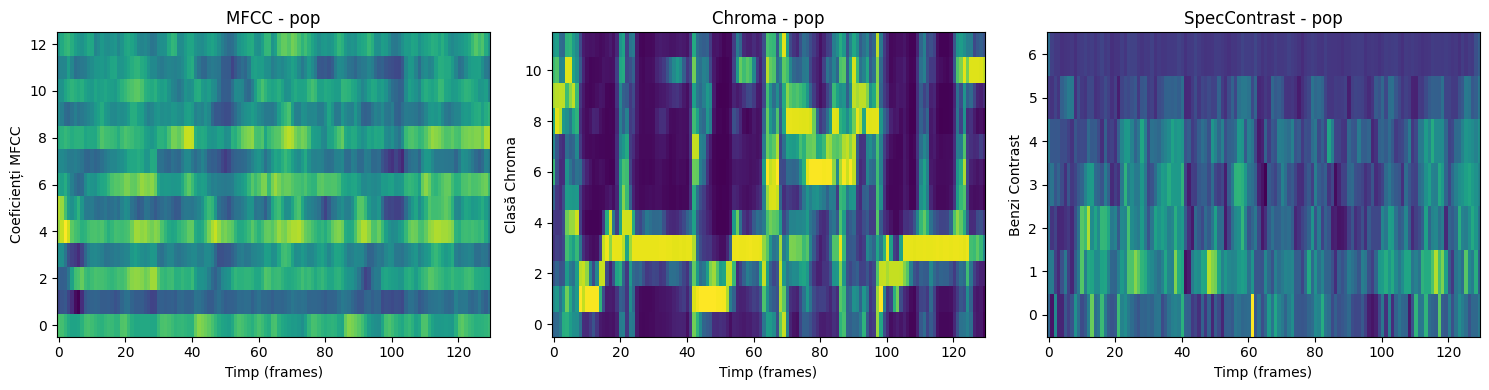

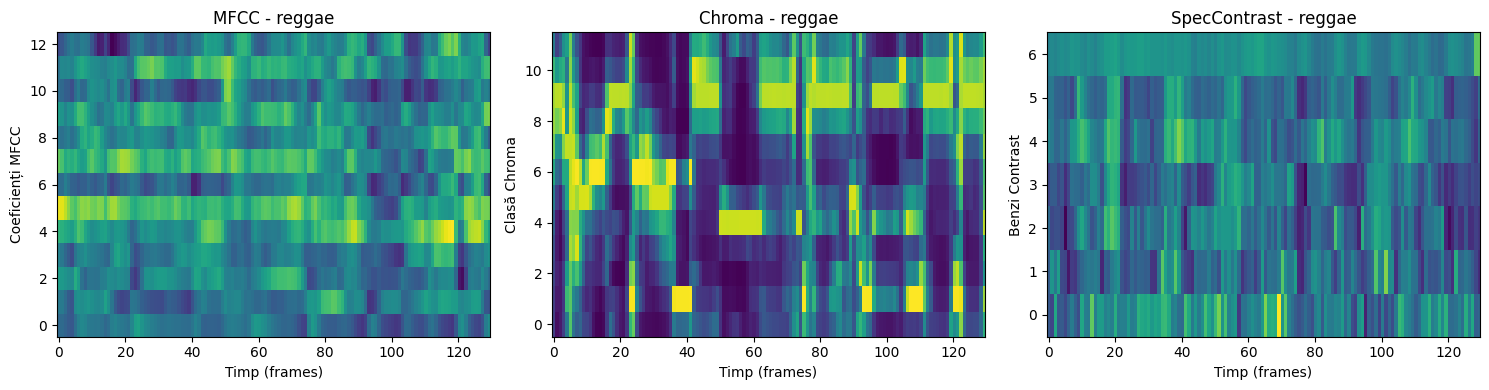

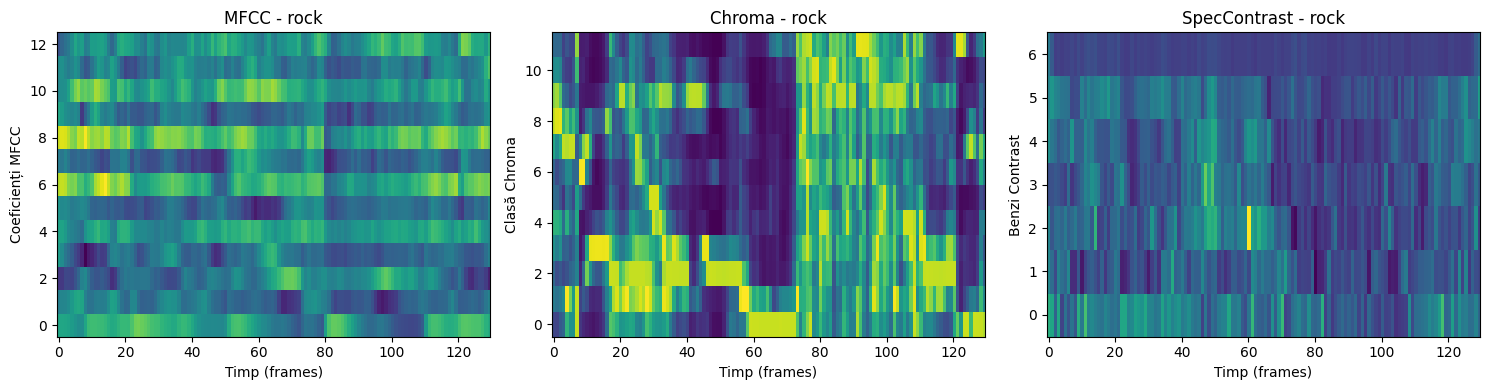

In [2]:
import random


def visualize_features_by_class(X, y, encoder):

    unique_classes = np.unique(y)

    for class_value in unique_classes:
        # Căutăm toate segmentele ce aparțin clasei curente
        indices = np.where(y == class_value)[0]
        if len(indices) == 0:
            continue

        # Alegem un segment aleator
        idx = random.choice(indices)

        # Reconstruim cele 3 feature-uri din concatenarea finală
        # MFCC = primele 13 rânduri
        mfcc = X[idx, 0:13, :]
        # Chroma = următoarele 12 rânduri
        chroma = X[idx, 13:25, :]
        # Spectral Contrast = ultimele 7 rânduri
        spec_contrast = X[idx, 25:32, :]

        # Inversăm "origin" la 'lower' (și aspect='auto') pentru afișare familiară
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        axs[0].imshow(mfcc, aspect='auto', origin='lower')
        axs[0].set_title(f"MFCC - {encoder.inverse_transform([class_value])[0]}")
        axs[0].set_xlabel("Timp (frames)")
        axs[0].set_ylabel("Coeficienți MFCC")

        axs[1].imshow(chroma, aspect='auto', origin='lower')
        axs[1].set_title(f"Chroma - {encoder.inverse_transform([class_value])[0]}")
        axs[1].set_xlabel("Timp (frames)")
        axs[1].set_ylabel("Clasă Chroma")

        axs[2].imshow(spec_contrast, aspect='auto', origin='lower')
        axs[2].set_title(f"SpecContrast - {encoder.inverse_transform([class_value])[0]}")
        axs[2].set_xlabel("Timp (frames)")
        axs[2].set_ylabel("Benzi Contrast")

        plt.tight_layout()
        plt.show()

visualize_features_by_class(X, y_numeric, encoder)


In [4]:
from sklearn.metrics import classification_report

# ----- Random Forest -----
print("Antrenăm modelul Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_numeric)
y_pred_rf = rf_model.predict(X_test_flat)
test_accuracy_rf = accuracy_score(y_test_numeric, y_pred_rf)
accuracies['Random Forest'] = test_accuracy_rf
print(f"Acuratețea Random Forest: {test_accuracy_rf:.4f}")
print(classification_report(y_test_numeric, y_pred_rf))


Antrenăm modelul Random Forest...
Acuratețea Random Forest: 0.6356
              precision    recall  f1-score   support

           0       0.55      0.79      0.65       571
           1       0.87      0.93      0.90       559
           2       0.66      0.46      0.54       592
           3       0.58      0.46      0.51       563
           4       0.74      0.42      0.54       583
           5       0.69      0.77      0.73       554
           6       0.69      0.90      0.78       558
           7       0.52      0.87      0.65       551
           8       0.64      0.51      0.56       588
           9       0.47      0.29      0.36       573

    accuracy                           0.64      5692
   macro avg       0.64      0.64      0.62      5692
weighted avg       0.64      0.64      0.62      5692



In [5]:
from sklearn.linear_model import LogisticRegression

# ----- Logistic Regression -----
print("Antrenăm modelul Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_flat, y_train_numeric)
y_pred_lr = lr_model.predict(X_test_flat)
test_accuracy_lr = accuracy_score(y_test_numeric, y_pred_lr)
accuracies['Logistic Regression'] = test_accuracy_lr
print(f"Acuratețea Logistic Regression: {test_accuracy_lr:.4f}")
print(classification_report(y_test_numeric, y_pred_lr))


Antrenăm modelul Logistic Regression...
Acuratețea Logistic Regression: 0.4798
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       571
           1       0.75      0.82      0.78       559
           2       0.43      0.41      0.42       592
           3       0.34      0.34      0.34       563
           4       0.39      0.33      0.36       583
           5       0.45      0.49      0.47       554
           6       0.69      0.75      0.72       558
           7       0.63      0.64      0.64       551
           8       0.30      0.27      0.28       588
           9       0.29      0.30      0.30       573

    accuracy                           0.48      5692
   macro avg       0.48      0.48      0.48      5692
weighted avg       0.47      0.48      0.48      5692



In [6]:
from xgboost import XGBClassifier

# ----- XGBoost -----
print("Antrenăm modelul XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric="logloss"
)
xgb_model.fit(X_train_flat, y_train_numeric)
y_pred_xgb = xgb_model.predict(X_test_flat)
test_accuracy_xgb = accuracy_score(y_test_numeric, y_pred_xgb)
accuracies['XGBoost'] = test_accuracy_xgb
print(f"Acuratețea XGBoost: {test_accuracy_xgb:.4f}")
print(classification_report(y_test_numeric, y_pred_xgb))


Antrenăm modelul XGBoost...
Acuratețea XGBoost: 0.6739
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       571
           1       0.89      0.91      0.90       559
           2       0.61      0.61      0.61       592
           3       0.60      0.54      0.57       563
           4       0.71      0.45      0.55       583
           5       0.71      0.77      0.74       554
           6       0.79      0.86      0.83       558
           7       0.66      0.83      0.73       551
           8       0.64      0.58      0.61       588
           9       0.47      0.47      0.47       573

    accuracy                           0.67      5692
   macro avg       0.67      0.68      0.67      5692
weighted avg       0.67      0.67      0.67      5692



In [7]:
import lightgbm as lgb

# ----- LightGBM -----
print("Antrenăm modelul LightGBM...")
train_data_lgb = lgb.Dataset(X_train_flat, label=y_train_numeric)
test_data_lgb = lgb.Dataset(X_test_flat, label=y_test_numeric, reference=train_data_lgb)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_numeric)),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42
}
lgb_model = lgb.train(params, train_data_lgb, num_boost_round=100, valid_sets=[test_data_lgb], callbacks=[lgb.early_stopping(stopping_rounds=10)])
y_pred_lgb = np.argmax(lgb_model.predict(X_test_flat), axis=1)
test_accuracy_lgb = accuracy_score(y_test_numeric, y_pred_lgb)
accuracies['LightGBM'] = test_accuracy_lgb
print(f"Acuratețea LightGBM: {test_accuracy_lgb:.4f}")
print(classification_report(y_test_numeric, y_pred_lgb))


Antrenăm modelul LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1060800
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 4160
[LightGBM] [Info] Start training from score -2.301832
[LightGBM] [Info] Start training from score -2.294336
[LightGBM] [Info] Start training from score -2.320056
[LightGBM] [Info] Start training from score -2.296579
[LightGBM] [Info] Start training from score -2.312422
[LightGBM] [Info] Start training from score -2.303338
[LightGBM] [Info] Start training from score -2.292098
[LightGBM] [Info] Start training from score -2.286896
[LightGBM] [Info] Start training from score -2.314706
[LightGBM] [Info] Start training from score -2.304092
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_loglos

In [8]:
from catboost import CatBoostClassifier

# ----- CatBoost -----
print("Antrenăm modelul CatBoost...")
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=False
)
catboost_model.fit(X_train_flat, y_train_numeric)
y_pred_catboost = catboost_model.predict(X_test_flat)
test_accuracy_catboost = accuracy_score(y_test_numeric, y_pred_catboost)
accuracies['CatBoost'] = test_accuracy_catboost
print(f"Acuratețea CatBoost: {test_accuracy_catboost:.4f}")
print(classification_report(y_test_numeric, y_pred_catboost))


Antrenăm modelul CatBoost...
Acuratețea CatBoost: 0.6040
              precision    recall  f1-score   support

           0       0.52      0.66      0.58       571
           1       0.85      0.90      0.87       559
           2       0.57      0.49      0.53       592
           3       0.52      0.46      0.49       563
           4       0.66      0.44      0.53       583
           5       0.63      0.67      0.65       554
           6       0.70      0.85      0.77       558
           7       0.56      0.83      0.67       551
           8       0.57      0.51      0.54       588
           9       0.41      0.26      0.32       573

    accuracy                           0.60      5692
   macro avg       0.60      0.61      0.59      5692
weighted avg       0.60      0.60      0.59      5692




Antrenăm modelul CNN...
After transpose:  (13280, 130, 32, 1)


/Users/mihaiosan/PycharmProjects/ProiectIA/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 130, 32, 256)   │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 8, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 8, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,338 (2.21 MB)

 Trainable params: 578,186 (2.21 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 176s 419ms/step - accuracy: 0.4857 - loss: 1.5320 - val_accuracy: 0.3398 - val_loss: 2.5456
Epoch 2/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 172s 413ms/step - accuracy: 0.7412 - loss: 0.7469 - val_accuracy: 0.7946 - val_loss: 0.5817
Epoch 3/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 165s 398ms/step - accuracy: 0.8232 - loss: 0.5173 - val_accuracy: 0.8176 - val_loss: 0.5575
Epoch 4/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 166s 401ms/step - accuracy: 0.8630 - loss: 0.4029 - val_accuracy: 0.8547 - val_loss: 0.4373
Epoch 5/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 168s 405ms/step - accuracy: 0.8912 - loss: 0.3147 - val_accuracy: 0.8638 - val_loss: 0.4186
Epoch 6/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 169s 407ms/step - accuracy: 0.9161 - loss: 0.2416 - val_accuracy: 0.8937 - val_loss: 0.3350
Epoch 7/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 168s 404ms/step - accuracy: 0.9358 - loss: 0.1871 - val_accuracy: 0.9037 - val_loss: 0.2998
Epoch 8/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 168s 406ms/step - accuracy: 0.9440 -

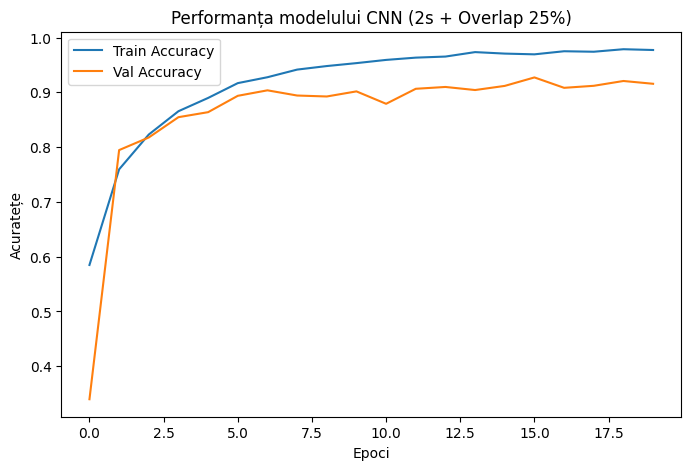

In [9]:
# =======================
# CNN
# pentru snippet de 2s => ~96 cadre
# =======================

print("\nAntrenăm modelul CNN...")

# 1) Dacă X_train_cnn are (batch, 32, 96, 1) inițial
# transpose(0,2,1,3).

X_train_cnn = np.transpose(X_train_cnn, (0, 2, 1, 3))
X_test_cnn  = np.transpose(X_test_cnn,  (0, 2, 1, 3))

print("After transpose: ", X_train_cnn.shape)

# 2) Definim arhitectura CNN
cnn_model = Sequential()

# Bloc 1: Conv(256) + Pool(2,2)
cnn_model.add(Conv2D(
    256, (3, 3), activation='relu', padding='same',
    input_shape=(130, 32, 1)   # height=96, width=32
))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
cnn_model.add(BatchNormalization())


# Bloc 2: Conv(128) + Pool(2,2)
cnn_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
cnn_model.add(BatchNormalization())


# Bloc 3: Conv(64) + Pool(2,1) => scade doar height
cnn_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
cnn_model.add(BatchNormalization())


# Bloc 4: Conv(64) + Pool(2,1) => scade iar height
cnn_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
cnn_model.add(BatchNormalization())


# Bloc 5: Conv(64), + un pooling pt. height=3
cnn_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(10, activation='softmax'))

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

# 3) Antrenare
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=20,
    batch_size=32
)

# 4) Evaluare
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
accuracies['CNN'] = test_acc_cnn

print(f"\nAcuratețea CNN: {test_acc_cnn:.4f}")

# 5) Plot evoluție
plt.figure(figsize=(8,5))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoci')
plt.ylabel('Acuratețe')
plt.title('Performanța modelului CNN (2s + Overlap 25%)')
plt.legend()
plt.show()



Comparăm acuratețea modelelor:
Random Forest: 0.6356
Logistic Regression: 0.4798
XGBoost: 0.6739
LightGBM: 0.7196
CatBoost: 0.6040
CNN: 0.9157


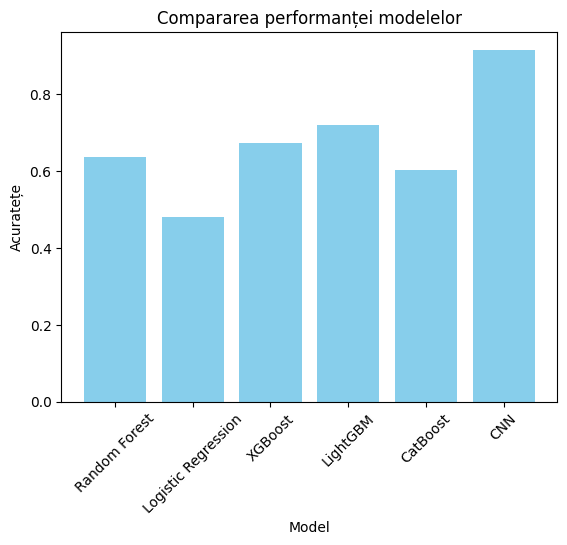

In [10]:
# ----- Compararea Performanței -----
print("\nComparăm acuratețea modelelor:")
for model, accuracy in accuracies.items():
    print(f"{model}: {accuracy:.4f}")

# Vizualizare Acuratețe
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.xlabel("Model")
plt.ylabel("Acuratețe")
plt.title("Compararea performanței modelelor")
plt.xticks(rotation=45)
plt.show()